# Library Imports

In [1]:
import os
import cv2
import numpy as np

# Data Visualisation
import matplotlib.pyplot as plt

#Preprocessing
import mediapipe as mp
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import utils, preprocessing
from tensorflow.keras.preprocessing.image import array_to_img


#Learning rate & decay
from tensorflow.keras.optimizers.schedules import ExponentialDecay

#Callbacks
from tensorflow.keras.callbacks import EarlyStopping
from tqdm.keras import TqdmCallback

# Model Training
from tensorflow.keras.optimizers import Adam
from tensorflow import convert_to_tensor
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from tensorflow.keras.applications import VGG19

objc[65944]: Class CaptureDelegate is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x15c7765a0) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_videoio.3.4.16.dylib (0x1372a0860). One of the two will be used. Which one is undefined.
objc[65944]: Class CVWindow is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x15c7765f0) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/mediapipe/.dylibs/libopencv_highgui.3.4.16.dylib (0x127feca68). One of the two will be used. Which one is undefined.
objc[65944]: Class CVView is implemented in both /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lewagon/lib/python3.10/site-packages/cv2/cv2.abi3.so (0x15c776618) and /Users/georgiantanaselea/.pyenv/versions/3.10.6/envs/lew

# Load Data

In [2]:
#directory with training data
train_dir = 'raw_data/archive/asl_alphabet_train/asl_alphabet_train'

In [3]:
def get_images(directory):
    """get images local and resizes them returning resized images and lables"""
    images = []
    labels = []

    directory_list = sorted(os.listdir(directory))
    for i in range(len(directory_list)):
        print(f"Getting images of {directory_list[i]}:")
        for image in os.listdir(directory + "/" + directory_list[i])[:10]:
            img = cv2.imread(directory + "/" + directory_list[i] + "/" + image)
            img = crop_image(img)
            img = cv2.resize(img, (32, 32))
            images.append(img)
            labels.append(directory_list[i])
            print(f"Got images of {directory_list[i]}: {len(images)}")
    return images, labels

# Preprocessing Data

In [5]:
def make_image_square(x_max, x_min, y_max, y_min):
    '''function used as a helper function in crop images to return a square image'''
    x_diff = x_max - x_min
    y_diff = y_max - y_min

    if y_diff > x_diff:

        length_diff =  y_diff - x_diff

        half_length_diff_max = round(length_diff/2)
        half_length_diff_min = length_diff-half_length_diff_max

        x_max = half_length_diff_max + x_max
        x_min = x_min - half_length_diff_min


    elif x_diff > y_diff:
        length_diff =  x_diff -  y_diff

        half_length_diff_max = round(length_diff/2)
        half_length_diff_min = length_diff-half_length_diff_max

        y_max = half_length_diff_max + y_max
        y_min = y_min - half_length_diff_min


    return x_max, x_min, y_max, y_min

def crop_image(image):
    '''a function to crop an image to just show their hands'''

    mp_hands = mp.solutions.hands

    mp_model = mp_hands.Hands(
        static_image_mode=True, # only static images
        max_num_hands=1, # max 2 hands detection
        min_detection_confidence=0.4) # detection confidence

    results = mp_model.process(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    h, w, c = image.shape # get image shape

    hand_landmarks = results.multi_hand_landmarks
        
    if results.multi_hand_landmarks:
        hand_landmarks = results.multi_hand_landmarks[0]
        image_height, image_width, _ = image.shape
        landmark_x = [landmark.x * image_width for landmark in hand_landmarks.landmark]
        landmark_y = [landmark.y * image_height for landmark in hand_landmarks.landmark]
        bbox = [min(landmark_x), min(landmark_y), max(landmark_x), max(landmark_y)]
        crop_img = image[int(bbox[1]):int(bbox[3]), int(bbox[0]):int(bbox[2])]
    else:
        crop_img = image
    pass

    return crop_img


def preprocessing(X, y):
    """Normalise our images and categorically encode our labels"""
    LE = LabelEncoder()
    X = np.array(X)
    X = X/255
    y = LE.fit_transform(y)
    #y = utils.to_categorical(y, num_classes = 29)
    return X, y

def train_val_test_split(X, y):
    """Split the dataset into 6 different datasets to validate model performance"""
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.4)
    X_val, X_test, y_val, y_test = train_test_split(X_val, y_val, test_size = 0.5)
    return X_train, X_val, X_test, y_train, y_val, y_test

In [16]:
#Loading and resizing the data by calling the get_images function
images, labels = get_images(train_dir)

Getting images of A:
Got images of A: 1
Got images of A: 2
Got images of A: 3
Got images of A: 4
Got images of A: 5
Got images of A: 6
Got images of A: 7
Got images of A: 8
Got images of A: 9
Got images of A: 10
Getting images of B:
Got images of B: 11
Got images of B: 12
Got images of B: 13
Got images of B: 14
Got images of B: 15
Got images of B: 16
Got images of B: 17
Got images of B: 18
Got images of B: 19
Got images of B: 20
Getting images of C:
Got images of C: 21
Got images of C: 22
Got images of C: 23
Got images of C: 24
Got images of C: 25
Got images of C: 26
Got images of C: 27
Got images of C: 28
Got images of C: 29
Got images of C: 30
Getting images of D:
Got images of D: 31
Got images of D: 32
Got images of D: 33
Got images of D: 34
Got images of D: 35
Got images of D: 36
Got images of D: 37
Got images of D: 38
Got images of D: 39
Got images of D: 40
Getting images of E:
Got images of E: 41
Got images of E: 42
Got images of E: 43
Got images of E: 44
Got images of E: 45
Got 

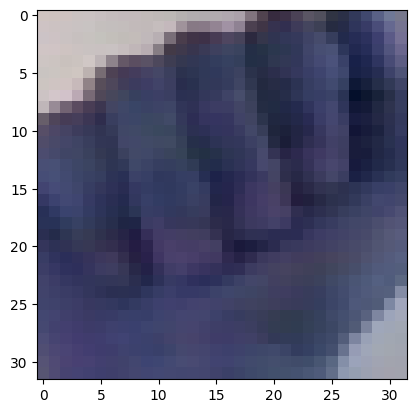

In [18]:
plt.imshow(images[2])

In [15]:
#Calling the train_val_test_split to get the required dataset splits to validate model performance
X_train, X_val, X_test, y_train, y_val, y_test = train_val_test_split(images, labels)
X_train, y_train = preprocessing(X_train, y_train)
X_val, y_val = preprocessing(X_val, y_val)
X_test, y_test = preprocessing(X_test, y_test)

NameError: name 'images' is not defined

# Model - Transfer Learning VGG19

## Loading VGG19 Model

In [110]:
def load_transfer_model():
    model = VGG19(include_top=False,
    weights="imagenet",
    input_shape=X_train.shape[1:])
    return model

In [111]:
def set_nontrainable_layers(model):
    
    model.trainable = False
    
    return model

## Adding Predictive Layer and Building the Model

In [112]:
def add_last_layers(model):
    '''Take a pre-trained model, set its parameters as non-trainable, and add additional trainable layers on top'''
    model = set_nontrainable_layers(model)
    flattening_layer = Flatten()
    dense_layer_1 = layers.Dense(128, activation='relu')
    dense_layer_2 = layers.Dense(64, activation='relu')
    dense_layer_3 = layers.Dense(32, activation='relu')
    prediction_layer = layers.Dense(29, activation='softmax')
    model = Sequential([
    model,
    flattening_layer,
    dense_layer_1,
    dense_layer_2,
    dense_layer_3,
    prediction_layer
    ])
    return model

In [113]:
#Setting up a learning rate exponential decay
lr_schedule = ExponentialDecay(
    0.001,
    decay_steps=100000,
    decay_rate=0.96,
    staircase=True)

In [114]:
def build_transfer_model():
    model = load_transfer_model()
    model = add_last_layers(model)
    opt = Adam(learning_rate = lr_schedule)
    model.compile(loss='sparse_categorical_crossentropy',
              optimizer=opt,
              metrics=['accuracy'])
    return model

In [118]:
model = build_transfer_model()

In [119]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg19 (Functional)          (None, 2, 2, 512)         20024384  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
 dense_1 (Dense)             (None, 64)                8256      
                                                                 
 dense_2 (Dense)             (None, 32)                2080      
                                                                 
 dense_3 (Dense)             (None, 29)                957       
                                                                 
Total params: 20,297,949
Trainable params: 273,565
Non-t

### Defining Early Stopping

In [120]:
es = EarlyStopping(monitor='val_loss', mode='max', verbose=1, patience = 5, restore_best_weights = True)

## Training Model

In [121]:
history = model.fit(X_train, y_train, validation_data = (X_val,y_val), epochs = 100, callbacks = [es, TqdmCallback(verbose = 0)], verbose = 0, batch_size=32)

0epoch [00:00, ?epoch/s]

2023-02-27 07:33:50.951186: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-02-27 07:33:51.288759: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2023-02-27 07:33:52.045615: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


KeyboardInterrupt: 

In [ ]:
def plot_results(history):

    plt.figure(figsize=(12, 12))
    plt.subplot(3, 2, 1)
    plt.plot(history.history['accuracy'], label = 'train_accuracy')
    plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.subplot(3, 2, 2)
    plt.plot(history.history['loss'], label = 'train_loss')
    plt.plot(history.history['val_loss'], label = 'val_loss')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.legend()
    plt.show()

In [ ]:
plot_results(history)

## Evaluating the Model

In [ ]:
loss, accuracy = model.evaluate(X_test, y_test)
loss, accuracy

### Evaluating the Model using WebCam Pictures

In [ ]:
webcam_test_data='raw_data/webcam-test'

In [ ]:
images_webcam_test, labels_webcam_test = get_images(webcam_test_data)

In [ ]:
X_test_webcam, y_test_webcam = preprocessing(images_webcam_test, labels_webcam_test)

In [ ]:
loss_webcam, accuracy_webcam = model.evaluate(X_test_webcam, y_test_webcam)
loss_webcam, accuracy_webcam